## <p style="text-align: center"> Predicting Professional Tennis Match Outcomes</p>

**Author:**  Carl Toews    

**Project Description:**  This project explores various machine learning techniques on professional tennis data.  The project combines two public data sets:  the first is a collection of player and match statistics from 1968 through the present (compiled by Jeff Sackmann:  https://github.com/JeffSackmann/tennis_atp) and the other is a collection of odds offered by major on-line gambling houses since 2001 (http://www.tennis-data.co.uk/alldata). 


**Data Description:** In Sackmann data there are over half a million records.  Player features change slightly over the years, but by 2017 include almost 50 elements, including rank, age, seed, and match statistics for both the winner and loser. In the odds data there are over 20,000 records.  Gambling houses change over the course of the years, but Pinnacle sports (which generally offers the best odds) has been around since 2010.  To do the analysis the two data sets need to be merged.  Due to inconsistent match names, winner records, dates, player names, etc., this is a major process.  The notebook [merge_datasets](./merge_datasets.ipynb) documents the process by which the data is cleaned and merged.  The notebook [setup_mysql](./setup_mysql.ipynb) provides Python code for transferring the raw CSV data into a MySQL database.   Some of the data that was cleaned and enhanced is stored in PKL files, also available on this github site.  

**Assessment strategy::**  To evaluate the success of predictive algorithms, we consider whether or not the prediction algorithm can make money against the betting markets.  This clearly depends on a betting strategy:

1.  **Strategy 1:** Bet a fixed amount $q$  on the higher ranked player, regardless of the difference in ranking points.  In this simulation, $q$ is taken to be $\$1$.   
2.  **Strategy 2:** Bet a fixed amount $q$ on the higher ranked player, but only if our assessed probability, say $p_1$, exceeds the implied probability of the odds market, say $p_2$.  
3.  **Strategy 3:** Bet an amount that grows or shrinks depending on by how much our probability exceeds that of the implied probabilty.  We use the Kelly criterion, where the amount staked is given by 
$$
q\frac{p \cdot (b+1)-1}{b}
$$ 
for some parameter $b$.
 

**Technical specs:** I've tested this notebook on Python 3.6.2 and MySQL 5.7.16.


**Outline:**    
I.  <a href="#logisticregression_1d"> One-dimensional logistic regression demo:  predicting with rank differences </a>  
II.  <a href="#logisticregression_nd"> $n$-dimensional logistic regression demo:  predicting with other features </a>  
III.  <a href="#svm"> SVM demo:  age and height difference    </a>  
IV.  <a href="#todos"> TODOs </a> 



**Configurable parameters**

In [2]:
pickle_dir = '../pickle_files/'
odds_file = 'odds.pkl'
matches_file = 'matches.pkl'

### I.  <a name="logisticregression_1d"> One-dimensional Logistic regression:  rank as predictor</a>  

We start out by performing logistic regression on rank alone, with the aim of seeing to what extent rank difference can be used as predictive tool.  The development is similar to the one here:

1.  *Clarke and Dyte, "Using official ratings to simulate major tennis tournaments", International Transactions in Operational Research, 2000.*

**Import statements**

We will need some scientific computing libraries (`scipy`), some data handling libraries (`pandas`), and some plotting functionality (`matplotlib`)

In [3]:
import numpy as np # numerical libraries
import scipy as sp
import pandas as pd # for data analysis
import pandas.io.sql as sql # for interfacing with MySQL database
from scipy import linalg # linear algebra libraries
from scipy import optimize
import matplotlib as mpl # a big library with plotting functionality
import matplotlib.pyplot as plt # a subset of matplotlib with most of the useful tools
import IPython as IP
%matplotlib inline 
import pdb # for debugging
from sklearn import linear_model as lm
#%qtconsole

Load the data.

In [4]:
odds= pd.read_pickle(pickle_dir + odds_file)
odds = odds.dropna(axis=0,subset=['PSW','PSL'])
matches= pd.read_pickle(pickle_dir + matches_file)
matches = matches.dropna(axis=0,subset=['winner_rank_points','loser_rank_points'])
data = pd.merge(matches,odds[['PSW','PSL','key']],how='inner',on='key')
IP.display.display(data[0:3])

,tourney_id,size,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,match_type,key,match_num,PSW,PSL
0,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,103794,NaN,None,...,11.0,8.0,7.0,4.0,9.0,atp_matches,0,11,2.25,1.74
1,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,104919,NaN,None,...,52.0,19.0,17.0,1.0,4.0,atp_matches,1,7,1.64,2.46
2,2010-1536,55,madrid masters,Clay,56,M,2010-05-09,104527,15.0,None,...,17.0,11.0,10.0,3.0,9.0,atp_matches,2,20,1.22,5.01


Separate data into training, validation, and test sets. (This division is not used for the plot above, but will be critical in assessing the performance of our learning algorithms.)

In [5]:
data['year'] = data['tourney_date'].map(lambda x: x.year)
training = data[data.year.isin([2010,2011,2012])]
validation = data[data.year.isin([2013,2014])]
test = data[data.year.isin([2015,2016])]

**Defining "success" and "failure"**

If the winner had a higher rank than the loser, the 'rank prediction' was considered a 'success', otherwise it is a 'failure'.  For analysis, we store only the absolute value of the rank difference, along with the outcome of the match.  We also scale the data for numerical well-behavedness.

In [6]:
# winner rank minus loser rank
rank_diff = (training['winner_rank_points'] - training['loser_rank_points']).values
# index variable:  True if higher ranked player won, False otherwise
y = (rank_diff > 0)
# final trainingset with two cols: difference in rankings, high ranked height minus low ranked height  
X = np.abs(rank_diff)
# for numerical well-behavedness, we need to scale and center the training
#X1=(X-np.mean(X,0))/np.std(X,axis=0)
X=X/np.std(X,axis=0)

**Define helper functions**

To perform the regression, we'll need to define the **sigmoid function** and a **cost function.**  The former can take a scalar, vector, or matrix, and return the elementwise value of

$$
\frac{1}{1+e^{-z}}
$$

In [7]:
def sigmoid(z):
    '''
    Usage:  sigmoid(z)
    
    Description:  Computes value of sigmoid function for scalar.  
    For vector or matrix, computes values of sigmoid function for each entry.
    '''

    return 1/(1+np.exp(-z));

The cost function is designed to take a regularization parameter lambda.  For a non-regularized solution, lambda can be set equal to 0.  The cost function returns both a cost and the gradient for any given value of parameters $\theta$.

In [8]:
# define a cost function
def costFunction(theta,X,y,lam,offset=True):
    '''
    Computes the cost and gradient for logistic regression.
    
    Input: 
           theta (mx1 numpy array of parameters)
           X (nxm numpy array of feature values, first column all 1s)
           y (nx1 boolean array of outcomes, 1=higher ranked player won, 0 otherwise)
           lam (scalar:  regularization paramter)
           offset (bool:  True of first element of theta represents a translation, False otherwise)
           
    Output:  
           cost (scalar value of cost)
    '''

    # number of data points
    n = len(y) 
    #number of parameters
    m = len(theta)   
 
    # make sure vectors are column vectors for use of "np.dot"
    theta = theta.reshape(-1,1)
    y = y.reshape(-1,1)
    X = X.reshape(-1,1) if m==1 else X
    
    # input to sigmoid function will be a column vector
    z = np.dot(X,theta) if len(theta) > 1 else X*theta
    
    # cost function
    regterms = np.arange(1,m) if offset else np.arange(0,m)
    #Tracer()() 
    J = (1/n)*(-np.dot(y.transpose(),np.log(sigmoid(z))) - \
                     np.dot((1-y.transpose()),np.log(1-sigmoid(z))) + \
                    (lam/(2))*np.sum(theta[regterms]**2))
  
    # gradient
    reggrad = np.insert(theta[regterms],0,0)
    grad = (1/n)*np.sum((sigmoid(z) - y)*X,0) + (lam/n)*reggrad
    
    
    return np.squeeze(J), np.squeeze(grad)

Small test:  make sure the cost function works.

In [9]:
# check that cost function works
theta = np.array([1.0])
lam = 0
cost, grad = costFunction(theta, X, y*1,lam)
print("cost:", cost)
print("grad:", grad)

cost: 0.6193777358026248
grad: 0.0038447065595027296


For diagnostic purposes, we define a `callback` function that will print information about the state and gradient as the optimization algorithm proceeds.  

In [10]:
def callbackF(theta):
    global NFeval
    global X
    global y
    global lam
    cost,grad = costFunction(theta,X,y*1,lam)
    print("%4d   %3.6f  %3.6f  %3.6f" % \
          (NFeval, theta, cost, grad)) 
    NFeval+=1

**Optimize**

Finally, we perform the logistic regression using scipy's built-in `optimization.minimize` function.

In [11]:
NFeval = 1
initial_theta = np.array([.1])
print("iter      theta     cost      grad  ")
res = sp.optimize.minimize(lambda t:  costFunction(t,X,y*1,lam), initial_theta, method='CG',\
                           jac=True,options={'maxiter':100,'disp':True},callback=callbackF)                             

iter      theta     cost      grad  
   1   0.942456  0.619296  -0.001086
   2   0.954714  0.619290  0.000000
Optimization terminated successfully.
         Current function value: 0.619290
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6


Plot the fit

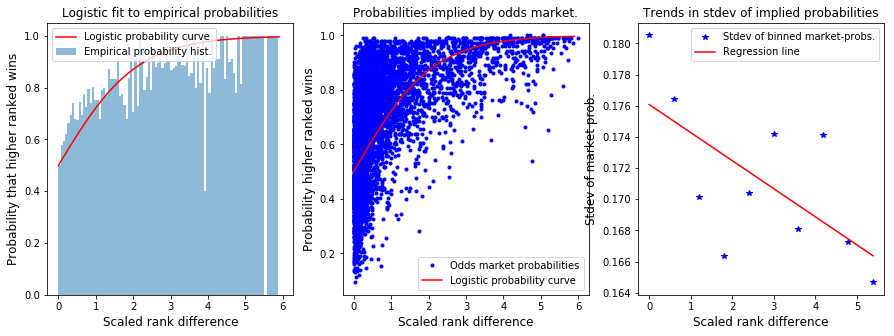

In [12]:
# define figure and axes
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

# figure A: predicted probabilities vs. empirical probs
hist, bin_edges = np.histogram(X,bins=100)
p = [np.sum(y[np.where((X>=bin_edges[i]) & (X<bin_edges[i+1]))[0]])/np.max([hist[i],1]) for i in np.arange(len(bin_edges)-1)]
bar_pos = np.arange(len(p))
bar_width = np.diff(bin_edges)
ax0.bar(bin_edges[0:-1], p, width=bar_width, align='edge', alpha=0.5)
r = np.arange(X.min(),X.max(),.1)
s = 1/(1+np.exp(-res.x*r))
ax0.plot(r,s,'r')
ax0.set_xlabel('Scaled rank difference',fontsize=12)
ax0.set_ylabel('Probability that higher ranked wins',fontsize=12)
ax0.set_title('Logistic fit to empirical probabilities',fontsize=12)
ax0.legend(['Logistic probability curve','Empirical probability hist.'])

# figure B:  probabilities predicted by odds market
ProbW = 1/training.PSW
ProbL = 1/training.PSL
idx = (training.winner_rank_points>training.loser_rank_points)
odds_prob=np.where(idx,ProbW,ProbL)
t = pd.DataFrame({'X':X,'odds_prob':odds_prob})
ts = t.sort_values('X')
ax1.plot(ts['X'],ts['odds_prob'],'.b')
ax1.plot(r,s,'r')
ax1.set_xlabel('Scaled rank difference',fontsize=12)
ax1.set_ylabel('Probability higher ranked wins',fontsize=12)
ax1.set_title('Probabilities implied by odds market.',fontsize=12)
ax1.legend(['Odds market probabilities','Logistic probability curve'])


# Fig C:  variance in odds probabilities as a function of rank difference
x_odds = ts['X'].values.reshape(len(ts),-1)
y_odds = ts['odds_prob'].values
hist, bin_edges = np.histogram(x_odds,bins=10)
stds = [np.std(y_odds[np.where((X>=bin_edges[i]) & (X<bin_edges[i+1]))]) for i in np.arange(len(bin_edges)-1)]
reg = lm.LinearRegression()
reg.fit (bin_edges[0:-1].reshape(10,1),stds)
yv=reg.predict(bin_edges[0:-1].reshape(10,1))
ax2.plot(bin_edges[0:-1],stds,'*b')
ax2.plot(bin_edges[0:-1],yv,'r')
ax2.set_xlabel('Scaled rank difference',fontsize=12)
ax2.set_ylabel('Stdev of market prob.',fontsize=12)
ax2.set_title('Trends in stdev of implied probabilities',fontsize=12)
ax2.legend(['Stdev of binned market-probs.','Regression line'])



**Double check**

Check: make sure we get the same thing using `scikit`'s canned logistic algorithm.

In [13]:
lr = lm.LogisticRegression(C=1., solver='lbfgs')
lr.fit(X.reshape(len(X),-1),y*1)
cofs = lr.coef_[0]
print("Regression coefficient from DIY approach:  {}".format(res.x))
print("Regression coefficient from Scikit approach:  {}".format(cofs[0]))

Regression coefficient from DIY approach:  [ 0.95471448]
Regression coefficient from Scikit approach:  0.6540809035972303


**Assessment**

While odds are published from a variety of betting houses, we use the ones from Pinnacle, which tend to be highest.  In all these simulations, we assume that the bettor starts with enough money to bankroll the entire series of matches.  


In [14]:
def calculate_daily_balances(probs,odds,strategy,b=1):
    """
    Calculates net-worth time-series for a given set of data, a fixed strategy, and a 
    value of the regression coefficient
    """

    nmatches = len(probs)
    investment = nmatches
    bet_idx = get_bet_idx(probs,odds,strategy)
    if strategy in [1,2]:
        stakes = np.abs(bet_idx) # in strategies 1 and 2, bet $1 every time
    else: # in strategy 3,size of bet varies with prob
        stakes = np.abs(bet_idx)*(probs*(b+1)-1)/b 
    gains = stakes*(bet_idx>0)*odds.PSW.values
    daily_movement = gains-stakes
    daily_balances = investment*np.ones(nmatches)   
    #pdb.set_trace()
    for i in np.arange(1,len(validation)):
        daily_balances[i]=daily_balances[i-1]+daily_movement[i]
    return daily_balances

def get_bet_idx(probs,odds,strategy):
    """
    calculates whether or not a bet is placed, and if so, on whom.
    returns 1 for "winner", -1 for "loser", and 0 for "no bet"
    """

    y = (rank_diff > 0)   # 1 if higher ranked player won, -1 otherwise
    
    #strategy 1:  always bet on higher ranked player
    if strategy==1:
        return y*2-1
    
    # strategies 2 and 3: bet on the higher ranked player if prob high
    if strategy in [2,3]:
        ProbW = 1/odds.PSW
        ProbL = 1/odds.PSL
        compProbs = np.where(y,ProbW,ProbL)
        bet_placed_idx = (probs>compProbs)
        return (y*2-1)*bet_placed_idx

In [23]:
# winner rank minus loser rank
rank_diff = (validation['winner_rank_points'] - validation['loser_rank_points']).values
# index variable:  True if higher ranked player won, False otherwise
y = (rank_diff > 0)
# final validationset with two cols: difference in rankings, high ranked height minus low ranked height  
X = np.abs(rank_diff)
# for numerical well-behavedness, we need to scale and center the validation
#X1=(X-np.mean(X,0))/np.std(X,axis=0)
X=X/np.std(X,axis=0)

probs = sigmoid(res.x*X)
odds = validation[['PSW','PSL']]

# loop over betting strategies
plotdata = {}
b = .25        # parameter for strategy #3
for i in np.arange(1,4):
    key='r'+str(i)
    value = calculate_daily_balances(probs,odds,i,b)
    plotdata[key]=value

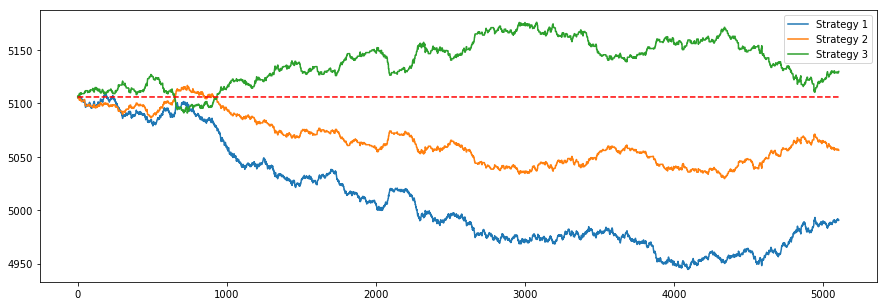

In [24]:
plot_bnd = len(validation)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
x = np.arange(len(validation))
tick = np.ones(len(validation))
for i in np.arange(1,4):
    ax.plot(x[0:plot_bnd],plotdata['r'+str(i)])
    
ax.legend(['Strategy 1','Strategy 2','Strategy 3'])
ax.plot(x[0:plot_bnd],len(validation)*tick[0:plot_bnd],'--r')


### II.  <a name="logisticregression_nd"> N-dimensional Logistic regression:  rank and height as predictor</a>  

Here we build the framework for incorporating mulitple features.  We focus on two, but the code allows for more.

In [69]:
# # extract from MySQL database info on rank points and height for both winner and loser, store in dataframe
# with engine.begin() as connection:
#     rawdata = pd.read_sql_query("""SELECT winner_rank_points, loser_rank_points, winner_ht, loser_ht FROM matches \
#                             WHERE tourney_date < '20150101' \
#                             AND tourney_date > '20110101'
#                             AND winner_rank_points IS NOT NULL \
#                             AND loser_rank_points IS NOT NULL \
#                             AND winner_ht IS NOT NULL \
#                             AND loser_ht IS NOT NULL""", connection)   

rawdata = matches[['winner_rank_points','loser_rank_points','winner_ht','loser_ht']].dropna(how='any')

In [71]:
# winner rank minus loser rank
rank_diff = (rawdata['winner_rank_points'] - rawdata['loser_rank_points']).values
# winner height minus loser height
ht_diff = (rawdata['winner_ht']-rawdata['loser_ht']).values
# index variable:  True if higher ranked player won, False otherwise
y = (rank_diff > 0)
# higher ranked height minus lower ranked height
rank_ht_diff = np.where(y==True, ht_diff,-ht_diff)
# final dataset with two cols: difference in rankings, high ranked height minus low ranked height  
X = np.column_stack([np.abs(rank_diff), rank_ht_diff])

In [72]:
# for numerical well-behavedness, we need to scale and center the data
X=(X-np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
# prepend column of 1s to X
X=np.insert(X,0,1,axis=1)

Balance the numbers of correct and incorrect predictions via oversampling.

In [73]:
# number of "True" minus the number of "False"
nsamps = sum(y) - sum(~y)
# the smaller class can be associated with either "True" or "False"
smallclass = bool(nsamps<0)
# sample with replacement from data of the appropriate class
samps = X[np.random.choice(np.where(y==smallclass)[0],size=nsamps),:]
# augment the old data
X1 = np.concatenate((X,samps),axis=0)
y1 = np.concatenate((y,np.zeros(nsamps,dtype=bool)))   

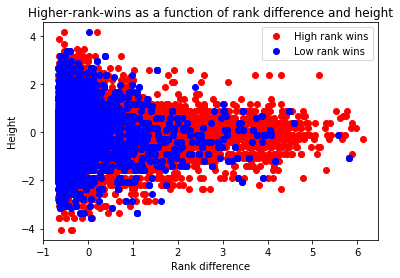

In [74]:
# plot the normalized data
fig, ax = plt.subplots(1,1)
ax.plot(X1[y1,1],X1[y1,2],"ro")
ax.plot(X1[~y1,1],X1[~y1,2],"bo")
ax.set_xlabel('Rank difference')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of rank difference and height')
ax.legend(['High rank wins','Low rank wins'])

To perform the regression, we'll need to define the sigmoid function and a cost function.  The former can take a scalar, vector, or matrix, and return the elementwise value of

$$
\frac{1}{1+e^{-z}}
$$

In [75]:
def sigmoid(z):
    '''
    Usage:  sigmoid(z)
    
    Description:  Computes value of sigmoid function for scalar.  
    For vector or matrix, computes values of sigmoid function for each entry.
    '''

    return 1/(1+np.exp(-z));

The cost function is designed to take a regularization parameter lambda.  For a non-regularized solution, lambda can be set equal to 0.  The cost function returns both a cost and the gradient for any given value of parameters $\theta$.

In [76]:
# define a cost function
def costFunction(theta,X,y,lam):
    '''
    Computes the cost and gradient for logistic regression.
    
    Input: 
           theta (3x1 vector of parameters)
           X (nx3 matrix of feature values, first column all 1s)
           y (nx1 binary vector of outcomes, 1=higher ranked player won, 0 otherwise)
           lam (scalar:  regularization paramter)
           
    Output:  
           cost (scalar value of cost)
    '''

    # number of data points
    m = len(y) 
    # make sure vectors are column vectors
    theta = theta.reshape(-1,1)
    y = y.reshape(-1,1)
    
    # input to sigmoid function will be a column vector
    z = np.dot(X,theta)
    
    # cost function
    J = (1/m)*np.sum(np.dot(-y.transpose(),np.log(sigmoid(z))) - \
                     np.dot((1-y.transpose()),np.log(1-sigmoid(z)))) + \
                    (lam/(2*m))*np.sum(theta[1:len(theta)+1]**2);
  
    # gradient
    regterm = np.insert(theta[1:len(theta)+1],0,0)
    grad = (1/m)*np.sum((sigmoid(z) - y)*X,0) + (lam/m)*regterm
    
    
    return J, grad

Small test:  make sure the cost function works.

In [77]:
# check that cost function works
theta = np.array([1,2,3])
lam = 0
cost, grad = costFunction(theta, X1, y1*1,lam)
print("cost:", cost)
print("grad:", grad)

cost: 1.2775752987
grad: [ 0.06604676  0.00915477  0.28375295]


For diagnostic purposes, we define a `callback` function that will print information about the state and gradient as the optimization algorithm proceeds.  

In [78]:
def callbackF(theta):
    global NFeval
    global X1
    global y1
    global lam
    cost,grad = costFunction(theta,X1,y1*1,lam)
    print("%4d   %3.6f   %3.6f   %3.6f   %3.6f   %3.6f  %3.6f  %3.6f" % \
          (NFeval, theta[0], theta[1], theta[2], cost, grad[0], grad[1], grad[2]))  
    NFeval+=1

Finally, we run the optimization.

In [79]:
# run optimization
NFeval = 1
initial_theta = np.array([-5,4,3])
#initial_theta = np.array([1])
#print("iter      t1          t2         t3     cost      grad1       grad2       grad3")
#res = sp.optimize.minimize(lambda t:  costFunction(t,X1,y1*1,lam), initial_theta, method='CG',\
#                           jac=True,options={'maxiter':100,'disp':True}, callback=callbackF)   
res = sp.optimize.minimize(lambda t:  costFunction(t,X1,y1*1,lam), initial_theta, method='CG',\
                           jac=True,options={'maxiter':100,'disp':True})                             

Optimization terminated successfully.
         Current function value: 0.660120
         Iterations: 11
         Function evaluations: 30
         Gradient evaluations: 30


To see how it did, we replot the data with the logistic classifier superimposed over the top.

(-5, 5)

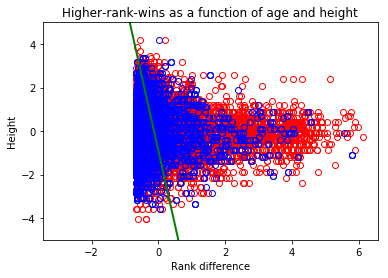

In [80]:
# plot the normalized data with regression line
theta = res.x
fig, ax = plt.subplots(1,1)
ax.plot(X1[y1,1],X1[y1,2],"ro",markerfacecolor="None")
ax.plot(X1[~y1,1],X1[~y1,2],"bo",markerfacecolor="None")
xplot = np.array([-3,3])
yplot = (-1/theta[2])*(theta[1]*xplot+theta[0])
ax.plot(xplot,yplot,'g',linewidth=2)
ax.set_xlabel('Rank difference')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of age and height')
ax.set_ylim((-5,5))

Also develop a quantitative measure of success:  count the number of correct predictions, and compare to what would have been predicted by rank alone.

In [81]:
rank_success_rate = np.sum(y)/len(y)
y_pred = (np.dot(X,theta)>0)
prediction_success_rate = np.sum(~(y^y_pred))/len(y)
print("prediction success rate: ", prediction_success_rate)
print("rank success rate: ", rank_success_rate)

prediction success rate:  0.535810944617
rank success rate:  0.665390454815


**Try to duplicate the above with sklearn's canned logistic algorithm**

(-5, 5)

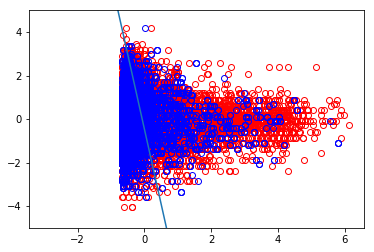

In [82]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1., solver='lbfgs')
t = lr.fit(X1,y1*1)
y=t.predict(X)
cofs = t.coef_[0]
yplot = (-1/cofs[2])*(cofs[1]*xplot+cofs[0])

fig, ax = plt.subplots(1,1)
ax.plot(X1[y1,1],X1[y1,2],"ro",markerfacecolor="None")
ax.plot(X1[~y1,1],X1[~y1,2],"bo",markerfacecolor="None")
plt.plot(xplot,yplot)
ax.set_ylim([-5,5])

**Comments:**

The above procedure turns tennis match outcomes into training data by assigning 1s to matches in which the higher ranked opponent won.  

TODO: 

1.  investigate other methods of classifying matches as 1s or 0s
2.  investigate other combinations of features to use for the regression
3.  test feature choices by dividing data set into training, validation, and test sets


## III.  <a name="svm"> SVM Demo </a>

This section uses some basic `scikit` functionality to train an SVM classifier on rank and ace data. The example is again a trivial one, but defines a workflow and sets the stage for investigating more complex relations.

In [83]:
# we'll use the SVM package in the scikit library
from sklearn import svm

After classifying the SVM classifier, we'll need some helper functions to form contour plots. These helper functions are borrowed from the `scikit` documentation, http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py.

In [84]:
# produce a dense grid of points in rectangle around the data
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# produce a contour plot with predicted outcomes from SVM classifier
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

We'll run our test on a slightly different set of data than last time.  Here, we'll still classify matches as `1` if the higher ranked player wins and `0` otherwise, but we'll focus on age and height as our predictive features.  

In [ ]:
# # extract from MySQL database info on rank points and height for both winner and loser, store in dataframe
# with engine.begin() as connection:
#     rawdata = pd.read_sql_query("""SELECT winner_rank_points, loser_rank_points, winner_age, loser_age, winner_ht, loser_ht \
#                             FROM matches \
#                             WHERE tourney_date > '20170101' \
#                             AND winner_rank_points IS NOT NULL \
#                             AND loser_rank_points IS NOT NULL \
#                             AND winner_age IS NOT NULL \
#                             AND loser_age IS NOT NULL \
#                             AND winner_ht IS NOT NULL \
#                             AND loser_ht IS NOT NULL""", connection)   

In [86]:
# this nx2 array contains the differences in ages and the differences in height
X = pd.concat([rawdata.iloc[:,2]-rawdata.iloc[:,3], \
               rawdata.iloc[:,4]-rawdata.iloc[:,5]], axis=1).values

# this nx1 binary array indicates whether the match was a "success" or a "failure", as predicted by ranking differences
y = (rawdata.iloc[:,0]-rawdata.iloc[:,1]).values > 0

IndexError: single positional indexer is out-of-bounds

In [ ]:
# for numerical well-behavedness, we need to scale and center the data
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

In [ ]:
# plot the normalized data 
fig, ax = plt.subplots(1,1)
ax.plot(X[y,0],X[y,1],"ro")
ax.plot(X[~y,0],X[~y,1],"bo")
ax.set_xlabel('Age')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of age and height')

We'll  use the `scikit` svm package to train an SVM classifier on this data.  We'll plot the results as a contour graph.

In [ ]:
# find the SVM classifier
clf = svm.SVC()
clf.fit(X, y) 

# generate a dense grid for producing a contour plot
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# feed the grid into the plot_contours routinge
fig, ax = plt.subplots(1, 1)
plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Rank points')
ax.set_ylabel('First serve %')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('SVM classifier for height/age data')

Note that these features produce a fairly mixed set of points, so they are unlikely to be highly predictive.  But it is interesting to note the pocket of blue in the lower left corner:  it suggests that, all other being equal, players who are younger and shorter are likely to fair worse than predicted.  

## IV.  Betting

In order to explore the profitability of our algorithms, we'll evaluate the success of our methods by comparing our predictions to those implied by the betting markets.  In order to do this, we need to establish a 1-1 correspondence between matches in the `odds` database and matches in the `matches` database.  

**Data wrangling**

Matching is not straightforward, unfortunately.   The `odds` data contains the variables `Location` and `Tournament`, while the `matches` data contains `tourney_name`.  But the names are not consistent across these datasets:  for example, the tournament "French Open" in `odds` is called "Roland Garros" in `matches`.  The `Location` variable in `odds` is generally a pretty close match to the `tourney_name` in `matches`, but not always.  Moreoever, the `date` variables differ slightly between these datasets:  sometimes, every match in a tournament is pegged with a single date (generally the start date), sometimes each match has the date it was actually played.  

Because the matching process is involved, I've put all the relevant code in another Jupyter notebook, [match_to_odds](./match_to_odds.ipynb).  There is a fair bit of ugly data wrangling involved:  my solution is ultimately to build a lookup table connecting `Location` in `odds` to `tourney_name` in matches, and then iterate on various  name matching schemes.  I focus on data in the 2010-2016 range.

-----

In [ ]:
odds= pd.read_pickle('../data/pickle_files/odds.pkl')
matches= pd.read_pickle('../data/pickle_files/matches.pkl')
rawdata = pd.merge(matches,odds[['PSW','PSL','key_o']].dropna(axis=0,subset=["PSW"]),how='inner',on='key_o')
%qtconsole

As a point of departure, consider a betting strategy of betting one dollar on each match, where you bet on the candidate with the highest rank.  

In [ ]:
investment = len(rawdata)
good_call_idx = (rawdata["LRank"]-rawdata["WRank"]>0)
winner_odds = rawdata["PSW"]
gain = sum(winner_odds*good_call_idx) 
roi = gain - investment

print("total invested:  ", investment)
print("return on investment:  ", roi)

Alternatively, we could follow the same strategy, but bet on whichever candidate had the highest odds:

In [ ]:
investment = len(rawdata)
good_call_idx = (rawdata["PSW"]-rawdata["PSL"]>0)
winner_odds = rawdata["PSW"]
gain = np.dot(winner_odds,good_call_idx) 
roi = gain - investment

print("total invested:  ", investment)
print("return on investment:  ", roi)

## IV.  <a name="todos"> TODOs </a>

This work is just the begining part of this analysis.  The gold standard for professional tennis match prediction is to beat the betting market.  There is odds data available for many of these matches, and the proper metric for predictive success is probably percentage increase in profit.

Further work includes the following:

1.  implement a neural net
2.  systematically investigate other combinations of features, including polynomial features
3.  use `join` commands to extract more complex subsets of the data (i.e. court-type specific data, players of a certain origin, players with certain tournament play patterns, etc.)
4.  benchmark algorithms against one another using expected winnings ideas